# Imbalanced Classification: Using Lending Club Loan Data

## Author: Arash Sadeghzadeh

Data for this notebook can be retrieved from the following URL:

https://www.kaggle.com/datasets/urstrulyvikas/lending-club-loan-data-analysis


In this notebook we explore different methodologies to tackle the imbalanced dataset. Some available sampleres from the imbalanced-learn toolbox are employed for the classification problem.
We use Lending Club Loan Data to illustrate the available methods.

## Table of Contents
* [Data Exploration](#first-bullet)
* [Classification Functions](#second-bullet)
    - [Logistic Regression](#21)
    - [Linear SVC](#22)
    - [SVC with Kernel](#23)
    - [Decision Tree](#24)
    - [Random Forest](#25)
    - [K Nearest Neighbours](#26)
    - [Bagging Classifier](#27)
    - [Gradient Boosting Classfier](#28)
* [Result Functions](#third-bullet)
* [Class Weight](#fourth-bullet)
* [Over Sampling](#fifth-bullet)
    - [RandomOverSampler](#51)
    - [ADASYN](#52)
    - [SMOTENC](#53)
    - [K Means SMOTE](#54)
    - [SVMSMOTE](#55)
    - [Borderline SMOTE](#56)
* [Under Sampling](#sixth-bullet)
    - [RandomUnderSampler](#61)
    - [ClusterCentroids](#62)
    - [NearMiss](#63)
    - [TomekLinks](#64)
    - [EditedNearestNeighbours](#65)
* [Combination of Over- and Under-Sampling Methods](#seventh-bullet)
    - [SMOTETomek](#71)
    - [SMOTEENN](#72)
* [Final Results](#eighth-bullet)
    


## Data Exploration <a class="anchor" id="first-bullet"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import boxcox
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SVMSMOTE, KMeansSMOTE, SMOTENC, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.neighbors import KNeighborsClassifier


In [2]:
warnings.filterwarnings('ignore', module='sklearn')

Let's first load the dataset:

In [3]:
data = pd.read_csv('loan_data.csv')

The columns of the dataset are as follows:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


Let's investigate whether there exist NaN values in the dataset:

In [5]:
data.isna().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Obviousely, we don't have any NaN values in the dataset.

Also, we have to check wheter there exist duplicate values in our dataset:

In [6]:
data.duplicated().sum()

0

Let's have a look at the descriptive statistics of our dataset:

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


In what follows, we investigate the number of unique values in each column, which helps us to categorize numerical features from the categorical features.

In [8]:
df_unique = pd.DataFrame(data.nunique(), columns=['No. of unique values'])
df_unique

,No. of unique values
credit.policy,2
purpose,7
int.rate,249
installment,4788
log.annual.inc,1987
dti,2529
fico,44
days.with.cr.line,2687
revol.bal,7869
revol.util,1035


Let's have a look at the skewness of the features:

In [9]:
# Choose columns to considered for the skewness
num_columns = df_unique[df_unique['No. of unique values']>20].index.tolist()
num_columns

['int.rate',
 'installment',
 'log.annual.inc',
 'dti',
 'fico',
 'days.with.cr.line',
 'revol.bal',
 'revol.util',
 'inq.last.6mths']

In [10]:
pd.DataFrame(data[num_columns].skew(numeric_only=True), columns=['skew'])

,skew
int.rate,0.164420
installment,0.912522
log.annual.inc,0.028668
dti,0.023941
fico,0.471260
days.with.cr.line,1.155748
revol.bal,11.161058
revol.util,0.059985
inq.last.6mths,3.584151


As one can see, some features are highly skewed.

We consider a limit of 0.5 to take care of skewed features:

In [11]:
skewed_columns = np.array(num_columns)[(data[num_columns].skew(numeric_only=True).abs() >0.5).values]
skewed_columns

array(['installment', 'days.with.cr.line', 'revol.bal', 'inq.last.6mths'],
      dtype='<U17')

Let's have a look at the distributions of the features in our dataset:

(0.0, 1.0, 0.0, 1.0)

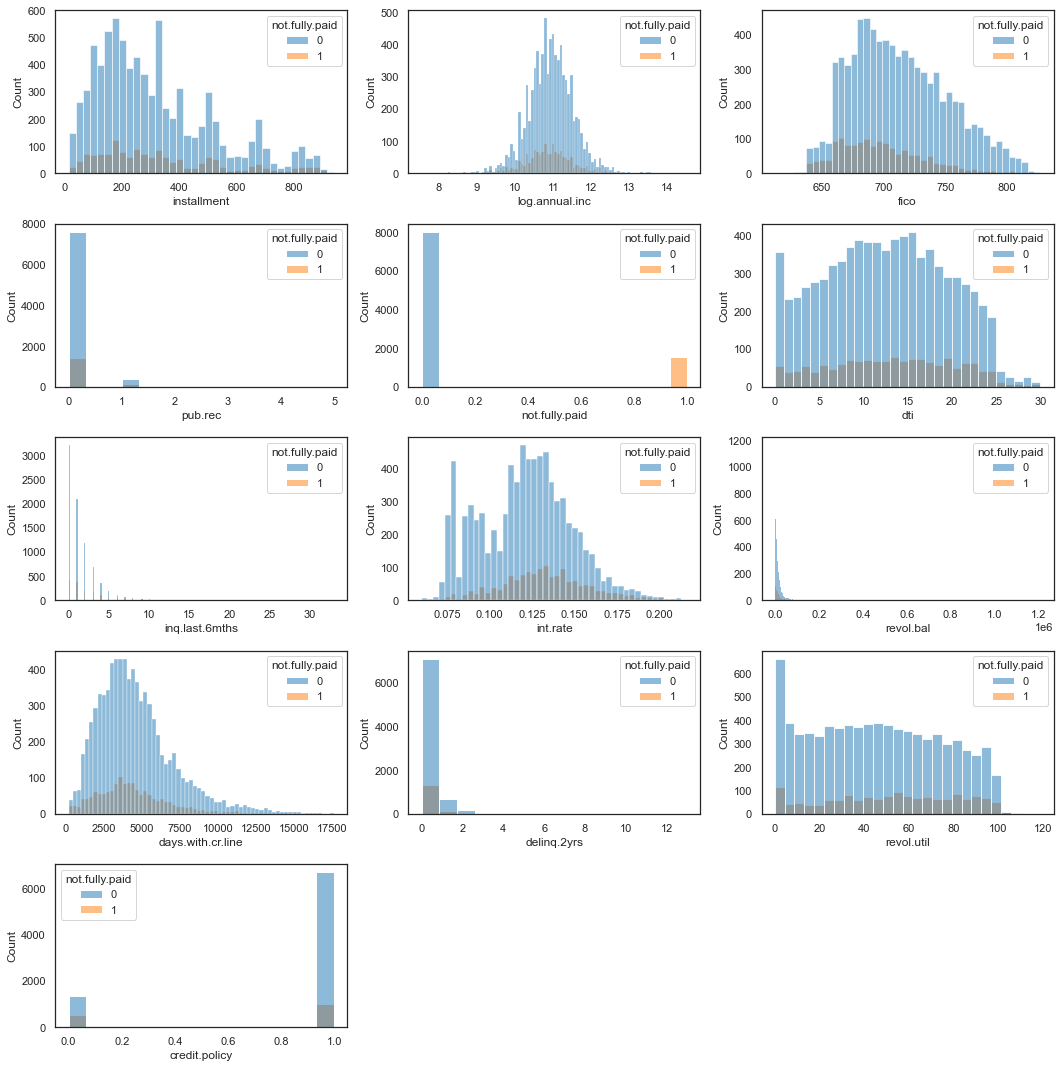

In [12]:
sns.set_style('white')
sns.set_context('notebook')

columns = list(set(data.columns)- set(['purpose']))

fig, axs = plt.subplots(5,3, figsize=(15,15))
for col, ax in zip(columns, axs.ravel()):
    sns.histplot(x=col, hue='not.fully.paid', data=data, ax=ax)

plt.tight_layout()
axs[4,1].axis('off')
axs[4,2].axis('off')

One of the categorical features in our dataset is the 'purpose'. In the figure below, you can see the various purposes and the related distributions:

<AxesSubplot:xlabel='count', ylabel='purpose'>

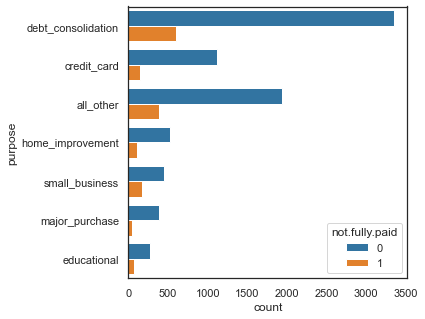

In [13]:
plt.subplots(1,1, figsize=(5,5))
sns.countplot(y='purpose', hue='not.fully.paid', data=data)

Now, we will take care of the skewness of those features having been already specified:

In [14]:
# To avoid error with boxcox
data[skewed_columns] = data[skewed_columns].replace({0:1e-3})
for col in skewed_columns:
    data[col], lmbda = boxcox(data[col])

print('Skewness after applying boxcox:')    
data[skewed_columns].skew()


Skewness after applying boxcox:


installment         -0.036842
days.with.cr.line    0.017046
revol.bal            0.006029
inq.last.6mths      -0.315241
dtype: float64

Now, let's have a look at the boxplots of the features:

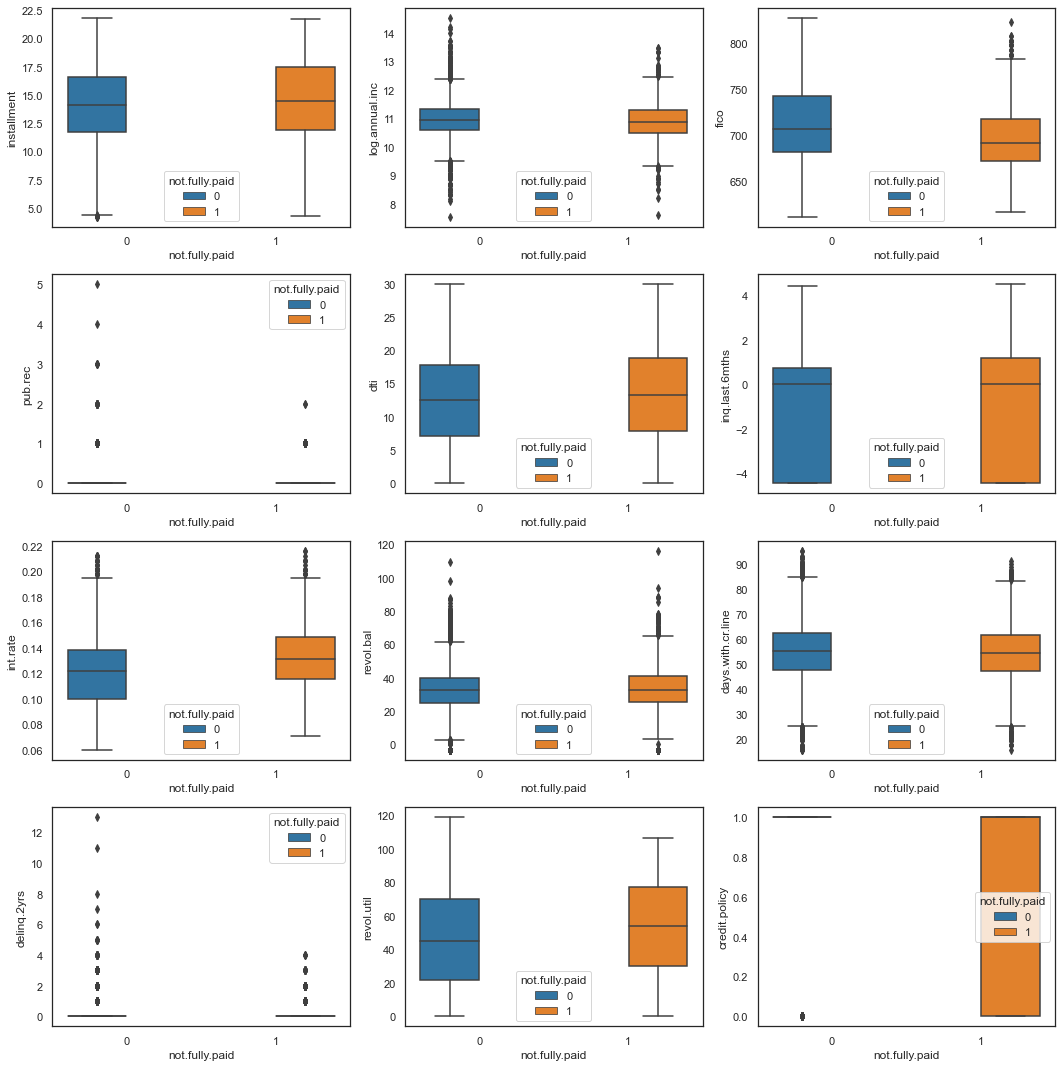

In [15]:
fig, axs = plt.subplots(4,3,figsize=(15,15))

columns = list(set(data.columns)- set(['not.fully.paid', 'purpose']))

for col, ax in zip(columns, axs.ravel()):
    sns.boxplot(x='not.fully.paid', y=col, data=data, ax=ax, hue='not.fully.paid')

plt.tight_layout()
plt.show()

### Choose Numerical Features

In this section, we specify the numerical features, then, we will choose those features which are more correlated to the target ('not.fully.paid').

In [16]:
num_columns

['int.rate',
 'installment',
 'log.annual.inc',
 'dti',
 'fico',
 'days.with.cr.line',
 'revol.bal',
 'revol.util',
 'inq.last.6mths']

The correlation between the numerical features and the target are as follows:

In [17]:
data[num_columns].corrwith(data['not.fully.paid'])

int.rate             0.159552
installment          0.042093
log.annual.inc      -0.033439
dti                  0.037362
fico                -0.149666
days.with.cr.line   -0.033920
revol.bal            0.026467
revol.util           0.082088
inq.last.6mths       0.116216
dtype: float64

As one can see, some features have low correlations with 'not.fully.paid'. Let's use PCA to choose most relevant features for the classification problem.

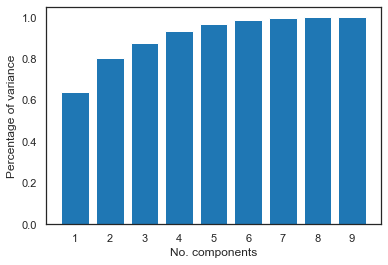

In [18]:
scaler = MaxAbsScaler()
data[num_columns] = scaler.fit_transform(data[num_columns])

pca = PCA()
pca.fit(data[num_columns])

pca_compon = np.cumsum(pca.explained_variance_ratio_)
plt.bar(x=np.arange(1,10), height=pca_compon)
ax = plt.gca()
ax.set(xlabel='No. components', ylabel='Percentage of variance', xticks=np.arange(1,10))
plt.show()

In [19]:
pd.DataFrame(pca_compon, index=np.arange(1,10), columns=['Percentage of variance'])

,Percentage of variance
1,0.638448
2,0.801290
3,0.874734
4,0.933087
5,0.966941
6,0.984714
7,0.996671
8,0.998722
9,1.000000


As one can see, using n_components=6, we can preserve around 99 percent of variance. This leads to reducing three columns from the dataset.

In [20]:
pca = PCA(n_components=6)
data_pca = pd.DataFrame(pca.fit_transform(data[num_columns]), 
                        columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6'])

In [21]:
data_without_num_columns = data.drop(columns=num_columns, axis=1)

In [22]:
data = pd.concat([data_pca,data_without_num_columns], axis=1)

### Choose Categorical Features

In this part, we specify the categorical features; then, we will check whether all categorical features are required to be used in the classification.

In [23]:
cat_columns = df_unique[df_unique['No. of unique values']<20].index.tolist()
cat_columns

['credit.policy', 'purpose', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']

In [24]:
data.corrwith(data['not.fully.paid'])

pca1              0.117496
pca2              0.086560
pca3              0.047374
pca4             -0.010728
pca5              0.082458
pca6              0.060436
credit.policy    -0.158119
delinq.2yrs       0.008881
pub.rec           0.048634
not.fully.paid    1.000000
dtype: float64

#### Purpose

Let's investigate whether purpose is a relevant feature for the classification. 

In [25]:
tab_purp_paid = data.groupby(['purpose','not.fully.paid']).agg('count')['pca1'].reset_index().rename(
                              columns={'pca1':'value'}).pivot(columns=['not.fully.paid'], index=['purpose'], values='value')

tab_purp_paid

not.fully.paid,0,1
purpose,,
all_other,1944,387
credit_card,1116,146
debt_consolidation,3354,603
educational,274,69
home_improvement,522,107
major_purchase,388,49
small_business,447,172


In [26]:
chi2_contingency(tab_purp_paid)

(96.98469589063261,
 1.0672453117980422e-18,
 6,
 array([[1957.91344748,  373.08655252],
        [1060.01148465,  201.98851535],
        [3323.66517018,  633.33482982],
        [ 288.10137816,   54.89862184],
        [ 528.32585091,  100.67414909],
        [ 367.0562748 ,   69.9437252 ],
        [ 519.92639382,   99.07360618]]))

Since the p-value is so small (1.06e-18) the null hypothesis that the output ('not.fully.paid') is independent of the 'purpose' is rejected. So we have to use 'purpose' as one of the features for our classification problem.

Since 'purpose' is a categorical feature, we need to convert it into dummy or indicator variables: 

In [27]:
data = pd.get_dummies(data=data, columns=['purpose'], drop_first=True )
data.head()

,pca1,pca2,pca3,pca4,pca5,pca6,credit.policy,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,-0.713368,0.232233,-0.148768,-0.296823,0.036045,-0.066899,1,0,0,0,0,1,0,0,0,0
1,-0.715702,0.233364,0.087133,0.093194,-0.045879,-0.138544,1,0,0,0,1,0,0,0,0,0
2,0.274826,-0.141905,-0.058845,-0.094353,0.076334,0.077043,1,0,0,0,0,1,0,0,0,0
3,0.266166,0.066425,0.232517,0.131375,-0.131660,-0.159960,1,0,0,0,0,1,0,0,0,0
4,-0.707192,0.000980,-0.097933,0.175653,0.044716,0.142974,1,1,0,0,1,0,0,0,0,0


#### credit.policy

Now, we will check the 'credit.policy':

In [28]:
tab_credit_paid = data.groupby(['credit.policy','not.fully.paid']).agg('count')['pca1'].reset_index().rename(
                              columns={'pca1':'value'}).pivot(columns=['not.fully.paid'], index=['credit.policy'], values='value')

tab_credit_paid

not.fully.paid,0,1
credit.policy,,
0,1349,519
1,6696,1014


In [29]:
chi2_contingency(tab_purp_paid)

(96.98469589063261,
 1.0672453117980422e-18,
 6,
 array([[1957.91344748,  373.08655252],
        [1060.01148465,  201.98851535],
        [3323.66517018,  633.33482982],
        [ 288.10137816,   54.89862184],
        [ 528.32585091,  100.67414909],
        [ 367.0562748 ,   69.9437252 ],
        [ 519.92639382,   99.07360618]]))

Again, the p-value is so small, so the null hypothesis that the 'not.fully.paid' is independent of 'credit.policy' is rejected. Therefore, we consider 'credit.policy as one of the features.

#### delinq.2yrs

Now, we will do the same for the 'delinq.2yrs':

In [30]:
tab_delinq_paid = data.groupby(['delinq.2yrs','not.fully.paid'])['pca1'].count().reset_index().rename(
                              columns={'pca1':'value'}).pivot(columns=['not.fully.paid'], index=['delinq.2yrs'], values='value')

tab_delinq_paid

not.fully.paid,0,1
delinq.2yrs,,
0,7121.0,1337.0
1,687.0,145.0
2,158.0,34.0
3,52.0,13.0
4,15.0,4.0
5,6.0,NaN
6,2.0,NaN
7,1.0,NaN
8,1.0,NaN


In [31]:
# put zero instead on NaN
tab_delinq_paid = tab_delinq_paid.replace({np.nan:0})
tab_delinq_paid

not.fully.paid,0,1
delinq.2yrs,,
0,7121.0,1337.0
1,687.0,145.0
2,158.0,34.0
3,52.0,13.0
4,15.0,4.0
5,6.0,0.0
6,2.0,0.0
7,1.0,0.0
8,1.0,0.0


In [32]:
chi2_contingency(tab_delinq_paid)

(5.330967923235079,
 0.8680013883658166,
 10,
 array([[7.10426081e+03, 1.35373919e+03],
        [6.98834830e+02, 1.33165170e+02],
        [1.61269576e+02, 3.07304239e+01],
        [5.45964711e+01, 1.04035289e+01],
        [1.59589685e+01, 3.04103153e+00],
        [5.03967425e+00, 9.60325747e-01],
        [1.67989142e+00, 3.20108582e-01],
        [8.39945709e-01, 1.60054291e-01],
        [8.39945709e-01, 1.60054291e-01],
        [8.39945709e-01, 1.60054291e-01],
        [8.39945709e-01, 1.60054291e-01]]))

Since, p-value is not small, so it seems that 'not.fully.paid' is independent of 'delinq.2yrs'. Therefore, 'delinq.2yrs' is deleted from the features.

In [33]:
data.drop('delinq.2yrs', axis=1, inplace=True)

In [34]:
data.head()

,pca1,pca2,pca3,pca4,pca5,pca6,credit.policy,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,-0.713368,0.232233,-0.148768,-0.296823,0.036045,-0.066899,1,0,0,0,1,0,0,0,0
1,-0.715702,0.233364,0.087133,0.093194,-0.045879,-0.138544,1,0,0,1,0,0,0,0,0
2,0.274826,-0.141905,-0.058845,-0.094353,0.076334,0.077043,1,0,0,0,1,0,0,0,0
3,0.266166,0.066425,0.232517,0.131375,-0.131660,-0.159960,1,0,0,0,1,0,0,0,0
4,-0.707192,0.000980,-0.097933,0.175653,0.044716,0.142974,1,0,0,1,0,0,0,0,0


#### pub.rec

Similarly, we investigate the 'pub.rec':

In [35]:
tab_pub_paid = data.groupby(['pub.rec','not.fully.paid']).agg('count')['pca1'].reset_index().rename(
                              columns={'pca1':'value'}).pivot(columns=['not.fully.paid'], index=['pub.rec'], values='value')

tab_pub_paid

not.fully.paid,0,1
pub.rec,,
0,7624.0,1395.0
1,397.0,136.0
2,17.0,2.0
3,5.0,NaN
4,1.0,NaN
5,1.0,NaN


In [36]:
tab_pub_paid = tab_pub_paid.replace({np.nan:0})
tab_pub_paid

not.fully.paid,0,1
pub.rec,,
0,7624.0,1395.0
1,397.0,136.0
2,17.0,2.0
3,5.0,0.0
4,1.0,0.0
5,1.0,0.0


In [37]:
chi2_contingency(tab_pub_paid)

(39.56110774714441,
 1.830777027585089e-07,
 5,
 array([[7.57547035e+03, 1.44352965e+03],
        [4.47691063e+02, 8.53089371e+01],
        [1.59589685e+01, 3.04103153e+00],
        [4.19972854e+00, 8.00271455e-01],
        [8.39945709e-01, 1.60054291e-01],
        [8.39945709e-01, 1.60054291e-01]]))

p-value is small, the null hypothesis is rejected. So, 'pub.rec' will be considered as one of the features.

In [38]:
data['pub.rec'].value_counts()

0    9019
1     533
2      19
3       5
4       1
5       1
Name: pub.rec, dtype: int64

In [39]:
data = pd.get_dummies(data=data, columns=['pub.rec'], drop_first=True )
data.head()

,pca1,pca2,pca3,pca4,pca5,pca6,credit.policy,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,pub.rec_1,pub.rec_2,pub.rec_3,pub.rec_4,pub.rec_5
0,-0.713368,0.232233,-0.148768,-0.296823,0.036045,-0.066899,1,0,0,1,0,0,0,0,0,0,0,0,0
1,-0.715702,0.233364,0.087133,0.093194,-0.045879,-0.138544,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0.274826,-0.141905,-0.058845,-0.094353,0.076334,0.077043,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0.266166,0.066425,0.232517,0.131375,-0.131660,-0.159960,1,0,0,1,0,0,0,0,0,0,0,0,0
4,-0.707192,0.000980,-0.097933,0.175653,0.044716,0.142974,1,0,1,0,0,0,0,0,0,0,0,0,0


Now that we have cleaned and prepared our dataset, we can split the dataset into independent variables and target set:

In [40]:
X = data.drop(columns=['not.fully.paid'], axis=1)
y = data['not.fully.paid']

Now, we split the dataset into train and test sets:

In [41]:
X_tra, X_tes, y_tra, y_tes = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1979)

In [42]:
y_tra.value_counts(normalize=True)

0    0.83999
1    0.16001
Name: not.fully.paid, dtype: float64

In [43]:
y_tes.value_counts(normalize=True)

0    0.83977
1    0.16023
Name: not.fully.paid, dtype: float64

## Classification Functions <a class="anchor" id="second-bullet"></a>

In this section, we will deifne the functions and methods used for the classification. Various methods are employed for the classification for the comparison purposes.

### Logistic Regression <a class="anchor" id="21"></a>

In [44]:
def logistic_reg(X_tra, y_tra, X_tes, y_tes, C_range=[1], class_weight=None):

    lr = LogisticRegression(n_jobs=-1, random_state=1979, class_weight=class_weight, max_iter=10000)
    param_grid = {'C': C_range}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
    gs.fit(X_tra, y_tra)

    y_pred = gs.predict(X_tes)
    y_prob = gs.predict_proba(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Logistic Regression')


    return y_pred, y_prob, res

### Linear SVC <a class="anchor" id="22"></a>

In [45]:
def linear_svc(X_tra, y_tra, X_tes, y_tes, C_range=[1], class_weight=None):
    
    lsvc = LinearSVC(random_state=1979, class_weight=class_weight, max_iter=10000)
    param_grid = {'C': C_range}
    gs = GridSearchCV(estimator=lsvc, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
    gs.fit(X_tra, y_tra)
    y_pred = gs.predict(X_tes)
        
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Linear SVC')


    return y_pred, res

### SVC with Kernel <a class="anchor" id="23"></a>

In [46]:
def kernel_svc(X_tra, y_tra, X_tes, y_tes, C_range=[1], class_weight=None):
    svc = SVC(class_weight=class_weight, random_state=1979, probability=True)
    param_grid = {'C':np.geomspace(1e-1,1e1, 10)}
    
    gd = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
    y_proba = gd.predict_proba(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='SVC with Kernel')


    return y_pred, y_proba, res

### Decision Tree <a class="anchor" id="24"></a>

In [47]:
def decision_tree(X_tra, y_tra, X_tes, y_tes, max_depth, max_features, class_weight=None):
    dtc = DecisionTreeClassifier(random_state=1979, class_weight=class_weight)
    param_grid = {'max_depth':max_depth, 'max_features':max_features}
    
    gd = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
    y_proba = gd.predict_proba(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Decision Tree')

    return y_pred, y_proba, res

### Random Forest <a class="anchor" id="25"></a>

In [48]:
def random_forest(X_tra, y_tra, X_tes, y_tes, max_depth, n_estimators, class_weight=None):
    rfc = RandomForestClassifier(n_jobs=-1, class_weight=class_weight)
    param_grid = {'max_depth':max_depth, 'n_estimators':n_estimators}
    
    gd = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
    y_proba = gd.predict_proba(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Random Forest')

    return y_pred, res

### K Nearest Neighbours <a class="anchor" id="26"></a>

In [49]:
def k_neighbors(X_tra, y_tra, X_tes, y_tes, n_neighbors):

    knc = KNeighborsClassifier(n_jobs=-1)
    param_grid = {'n_neighbors':n_neighbors}
    
    gd = GridSearchCV(estimator=knc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
        
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='K Nearset Neighbors')

    return y_pred, res

### Bagging Classifier <a class="anchor" id="27"></a>

In [50]:
def bagging_classifier(X_tra, y_tra, X_tes, y_tes, n_estimators, max_samples, max_features, class_weight):
    
    base_estim = DecisionTreeClassifier(class_weight=class_weight, random_state=1979)
    bc = BaggingClassifier(base_estimator=base_estim, n_jobs=-1, random_state=1979)
    param_grid = {'n_estimators':n_estimators, 'max_samples':max_samples, 'max_features':max_features}
    
    gd = GridSearchCV(estimator=bc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Bagging Classifier')

    return y_pred, res  

### Gradient Boosting Classfier <a class="anchor" id="28"></a>

In [51]:
def gradient_boosting(X_tra, y_tra, X_tes, y_tes, n_estimators, max_depth, max_features):
    
    gbc = GradientBoostingClassifier()
    param_grid = {'n_estimators':n_estimators, 'max_depth':max_depth, 'max_features':max_features}
    
    gd = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
    gd.fit(X_tra, y_tra)
    y_pred = gd.predict(X_tes)
    
    accu_sco = accuracy_score(y_true=y_tes, y_pred=y_pred)
    roc_sco = roc_auc_score(y_true=y_tes, y_score=y_pred)
    prec_sco, reca_sco, f1_sco, _ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred,
                                                                    pos_label=1, average='macro')
    res = pd.Series({'Precision':prec_sco, 'Recall':reca_sco, 'F1 Score':f1_sco, 'Accuracy':accu_sco,
               'ROC_AUC':roc_sco }, name='Gradient Boosting')

    return y_pred, res 

## Result Functions <a class="anchor" id="third-bullet"></a>

In this section, the required functions to represent the results are given:

This function illustrates the confusion matrix and the ROC curve.

In [52]:
def result_rep(y_true, y_pred, y_proba):
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

    sns.set_style=('white')
    sns.set_context('notebook')
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='plasma', ax=axs[0])
    axs[0].set_xlabel('Prediction')
    axs[0].set_ylabel('Ground Truth')
    axs[0].set_title('Confucion Matrix')

    fpr, tpr, thr = roc_curve(y_true=y_true, y_score=y_proba[:,1])
    axs[1].plot(fpr,tpr)
    axs[1].plot([0, 1], [0, 1], 'r--')
    axs[1] = plt.gca()
    axs[1].set(xlim=[0, 1], ylim=[0, 1], xlabel='False Positive', ylabel='True Positive', title='ROC Curve')

    plt.show()

 A function to illustrate the confusion matrix:

In [53]:
def confusion_rep(y_true, y_pred):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

    sns.set_style=('white')
    sns.set_context('notebook')
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='plasma')
    ax = plt.gca()
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    ax.set_title('Confucion Matrix')

    plt.show()

The function below shows the number of different classes in the target variable:

In [54]:
def resample_rep(y):
    res = pd.DataFrame(y.value_counts()).reset_index().rename(
            columns={'not.fully.paid':'No. of Samples', 'index':'Class'}).set_index('Class')
    return res

A function to stack the results obtained by different methods:

In [55]:
def satck_res (result, Resample):
    res = result.stack().reset_index().rename(
         columns={'level_0':'Metric', 'level_1':'Classification Method', 0:'Value'})
    res['Resample']= Resample
    return res

The following function is the main function which is used for the classification considering various methods:

In [56]:
def classification_different_models(X_tra, y_tra, X_tes, y_tes, class_weight=None):
    
    list_res = list()

    y_pred, y_prob, res = logistic_reg(X_tra, y_tra, X_tes, y_tes,
                                      C_range=np.geomspace(0.1,10,10), class_weight=class_weight)
    list_res.append(res)

    y_pred, res = linear_svc(X_tra, y_tra, X_tes, y_tes, 
                                   C_range=np.geomspace(0.1,10,10), class_weight=class_weight)
    list_res.append(res)

    y_pred, y_proba, res = kernel_svc(X_tra, y_tra, X_tes, y_tes, 
                                   C_range=np.geomspace(0.1,10,10), class_weight=class_weight)
    list_res.append(res)

    y_pred, y_proba, res = decision_tree(X_tra, y_tra, X_tes, y_tes, max_depth=np.linspace(3,1000,10, dtype=int),
                                max_features=[3,5,7,10,15,20], class_weight=class_weight)
    list_res.append(res)

    y_pred, res = random_forest(X_tra, y_tra, X_tes, y_tes, max_depth=np.linspace(3,1000,10, dtype=int),
                                n_estimators=[100, 300, 500, 1000], class_weight=class_weight)
    list_res.append(res)

    y_pred, res = k_neighbors(X_tra, y_tra, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
    list_res.append(res)

    y_pred, res = bagging_classifier(X_tra, y_tra, X_tes, y_tes, n_estimators=[100, 500], 
                                     max_samples=[0.3, 0.7, 1], max_features=[0.1, 0.3, 0.7, 1], class_weight=class_weight)
    
    list_res.append(res)
    
    y_pred, res = gradient_boosting(X_tra, y_tra, X_tes, y_tes, n_estimators=[100, 500], max_depth=[3, 5, 7],
                      max_features=[0.1, 0.3, 0.7, 1.0])
    
    list_res.append(res)

    res = pd.concat(list_res, axis=1)
    
    return res

## Class Weight <a class="anchor" id="fourth-bullet"></a>

In this section, we will take care of our imbalanced dataset using the 'class weight' available in some classifiaction methods.

First of all, we apply the classification methods on our dataset without using 'class weight' or any imbalnced resamplers just to investigate the performance of the classifiers on the dataset for the later comparisons.

In [57]:
print(resample_rep(y_tra))

ros_withoutClassWeight = classification_different_models(X_tra, y_tra, X_tes, y_tes, class_weight=None)
df1 = satck_res(ros_withoutClassWeight, 'Ignore')
ros_withoutClassWeight

       No. of Samples
Class                
0                6436
1                1226


,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.810231,0.419885,0.733360,0.524728,0.608289,0.539529,0.586824,0.577401
Recall,0.510779,0.500000,0.507211,0.526075,0.506664,0.539737,0.502014,0.516886
F1 Score,0.479205,0.456454,0.472512,0.525270,0.474261,0.539631,0.462485,0.501868
Accuracy,0.842380,0.839770,0.840814,0.737474,0.837683,0.751566,0.838727,0.828288
ROC_AUC,0.510779,0.500000,0.507211,0.526075,0.506664,0.539737,0.502014,0.516886


Best F1 score is obtained by: K Nearset Neighbors


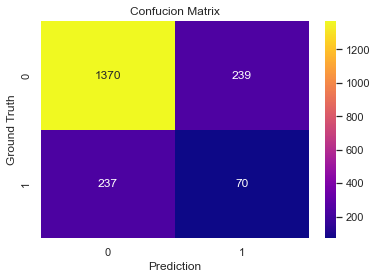

In [58]:
print('Best F1 score is obtained by: {}'.format(ros_withoutClassWeight
                                                .columns[ros_withoutClassWeight.loc['F1 Score'].argmax()]))

y_pred, res = k_neighbors(X_tra, y_tra, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
confusion_rep(y_tes, y_pred)


Now, we use 'class weight' to tackle the imbalance of the target variable.

In [59]:
print(resample_rep(y_tra))

ros_withCalssWeight = classification_different_models(X_tra, y_tra, X_tes, y_tes, class_weight={1:0.6, 0:0.4})
df2 = satck_res(ros_withCalssWeight, 'ClassWeight')
ros_withCalssWeight

       No. of Samples
Class                
0                6436
1                1226


,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.740315,0.779067,0.726957,0.518483,0.531143,0.539529,0.519937,0.633509
Recall,0.527526,0.515044,0.520005,0.520096,0.501082,0.539737,0.500386,0.533483
F1 Score,0.513604,0.488287,0.499306,0.518964,0.461961,0.539631,0.459171,0.528886
Accuracy,0.843946,0.842902,0.842380,0.729645,0.837161,0.751566,0.838205,0.834029
ROC_AUC,0.527526,0.515044,0.520005,0.520096,0.501082,0.539737,0.500386,0.533483


As one can see, the performances of the classifiers are improved utilizing the 'class-weight' capability in some classifiers.

Best F1 score is obtained by: K Nearset Neighbors


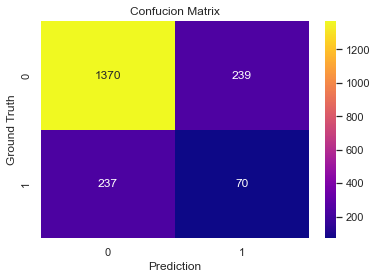

In [60]:
print('Best F1 score is obtained by: {}'.format(ros_withCalssWeight
                                                .columns[ros_withCalssWeight.loc['F1 Score'].argmax()]))

y_pred, res = k_neighbors(X_tra, y_tra, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
confusion_rep(y_tes, y_pred)

## Over Sampling <a class="anchor" id="fifth-bullet"></a>

In this section, we will explore different available oversampling methods and their applications on our dataset.

### RandomOverSampler <a class="anchor" id="51"></a>

One way to fight the imbalance of the classes is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples [imbalanced-learn toolbox]. 

In [61]:
ros = RandomOverSampler(random_state=1979)
X_tra_re, y_tra_re = ros.fit_resample(X_tra, y_tra)

ros_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df3 = satck_res(ros_res, 'RandomOverSampler')
ros_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.573979,0.572214,0.571254,0.516546,0.585990,0.539529,0.620514,0.556954
Recall,0.631696,0.628439,0.624421,0.516849,0.517818,0.539737,0.504650,0.524075
F1 Score,0.553053,0.551240,0.555200,0.516684,0.502750,0.539631,0.468664,0.520338
Accuracy,0.640397,0.639353,0.650313,0.737474,0.829854,0.751566,0.838727,0.811587
ROC_AUC,0.631696,0.628439,0.624421,0.516849,0.517818,0.539737,0.504650,0.524075


In the above table, you can see the obtained results using various classifiers.

Furthermore, the confusion matrix and the ROC curve are given below.

Best F1 score is obtained by: SVC with Kernel


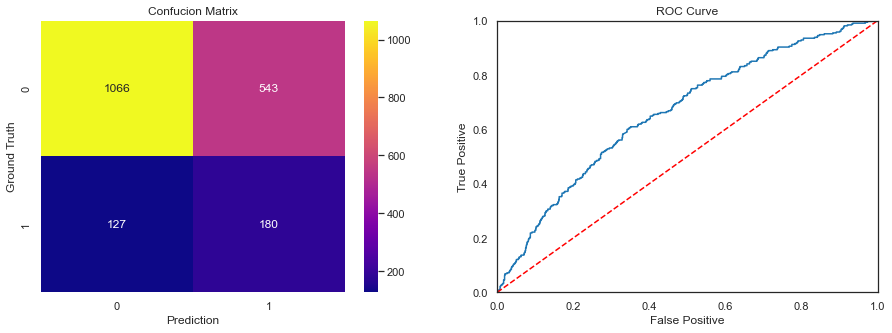

In [62]:
print('Best F1 score is obtained by: {}'.format(ros_res.columns[ros_res.loc['F1 Score'].argmax()]))

y_pred, y_proba, res = kernel_svc(X_tra_re, y_tra_re, X_tes, y_tes, 
                                   C_range=np.geomspace(0.1,10,10), class_weight=None)

result_rep(y_tes, y_pred, y_proba)

### ADASYN <a class="anchor" id="52"></a>

The Adaptive Synthetic (ADASYN) sampling method is used in this subsection to tackle the imbalance of the classes.

In [63]:
ada = ADASYN(random_state=1979, n_jobs=-1, n_neighbors=3)
X_tra_re, y_tra_re = ada.fit_resample(X_tra, y_tra)

ada_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df4 = satck_res(ada_res, 'ADASYN')
ada_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.571018,0.571018,0.541619,0.538286,0.545677,0.533983,0.554025,0.532406
Recall,0.625728,0.625728,0.574745,0.555088,0.540841,0.546956,0.552156,0.539928
F1 Score,0.551240,0.551240,0.511509,0.536620,0.542683,0.533185,0.553026,0.533592
Accuracy,0.641441,0.641441,0.602296,0.691023,0.766701,0.697286,0.763570,0.718685
ROC_AUC,0.625728,0.625728,0.574745,0.555088,0.540841,0.546956,0.552156,0.539928


Best F1 score is obtained by: Bagging Classifier


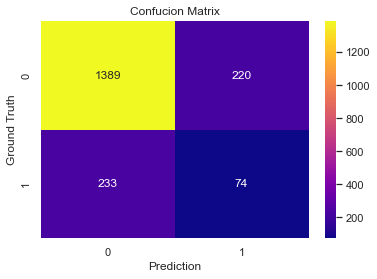

In [64]:
print('Best F1 score is obtained by: {}'.format(ada_res.columns[ada_res.loc['F1 Score'].argmax()]))

y_pred, res = bagging_classifier(X_tra_re, y_tra_re, X_tes, y_tes, n_estimators=[100, 500], 
                                 max_samples=[0.3, 0.7, 1], max_features=[0.1, 0.3, 0.7, 1], class_weight=None)

confusion_rep(y_tes, y_pred)

### SMOTENC <a class="anchor" id="53"></a>

The SMOTENC is an extension of the SMOTE (Synthetic Minority Oversampling Technique) algorithm when we are dealing with mixed data type  (continuous and categorical features).

In [65]:
# We need first specify the categorical and numerical features
mask = [False, False, False, False, False, False,
        True, True, True, True, True, True,
        True, True, True, True, True, True]

smt = SMOTENC(random_state=1979, k_neighbors=5, n_jobs=-1, categorical_features=mask)
X_tra_re, y_tra_re = smt.fit_resample(X_tra, y_tra)

smt_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df5 = satck_res(smt_res, 'SMOTENC')
smt_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.535637,0.536176,0.521101,0.529640,0.526851,0.527877,0.524596,0.512738
Recall,0.562970,0.564513,0.537897,0.544983,0.527554,0.541115,0.525304,0.516258
F1 Score,0.509589,0.507474,0.487149,0.523509,0.527172,0.523242,0.524913,0.511278
Accuracy,0.609081,0.602818,0.582463,0.669624,0.742171,0.676409,0.740605,0.698852
ROC_AUC,0.562970,0.564513,0.537897,0.544983,0.527554,0.541115,0.525304,0.516258


Best F1 score is obtained by: Random Forest


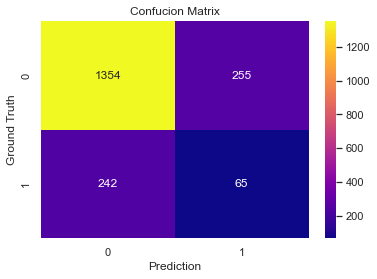

In [66]:
print('Best F1 score is obtained by: {}'.format(smt_res.columns[smt_res.loc['F1 Score'].argmax()]))

y_pred, res = random_forest(X_tra_re, y_tra_re, X_tes, y_tes, max_depth=np.linspace(3,1000,10, dtype=int),
                                n_estimators=[100, 300, 500, 1000], class_weight=None)
confusion_rep(y_tes, y_pred)

### K Means SMOTE <a class="anchor" id="54"></a>

In this section, we use K Means SMOTE which is based on k-means clustering and SMOTE oversampling to achieve a balanced class distribution.  

In [67]:
kms = KMeansSMOTE(n_jobs=-1, random_state=1979, cluster_balance_threshold=0.1)
X_tra_re, y_tra_re = kms.fit_resample(X_tra, y_tra)

kms_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df6 = satck_res(kms_res, 'KMeansSMOTE')
kms_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.557621,0.554910,0.555293,0.540361,0.582362,0.543108,0.594585,0.537795
Recall,0.591432,0.589171,0.571644,0.551864,0.552361,0.551340,0.564844,0.532623
F1 Score,0.553112,0.547538,0.558628,0.541995,0.558534,0.545371,0.572778,0.534293
Accuracy,0.679019,0.668580,0.725470,0.716597,0.803758,0.731211,0.804802,0.766180
ROC_AUC,0.591432,0.589171,0.571644,0.551864,0.552361,0.551340,0.564844,0.532623


Best F1 score is obtained by: Bagging Classifier


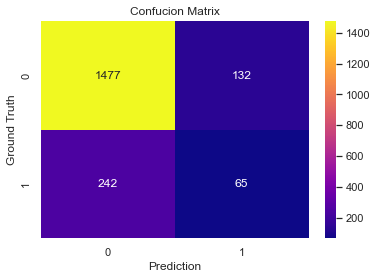

In [68]:
print('Best F1 score is obtained by: {}'.format(kms_res.columns[kms_res.loc['F1 Score'].argmax()]))

y_pred, res = bagging_classifier(X_tra_re, y_tra_re, X_tes, y_tes, n_estimators=[100, 500], 
                                     max_samples=[0.3, 0.7, 1], max_features=[0.1, 0.3, 0.7, 1], class_weight=None)
 
confusion_rep(y_tes, y_pred)

### SVMSMOTE <a class="anchor" id="55"></a>

Another method for the oversampling is SVMSMOTE. Thsi method is a variant of SMOTE algorithm which use an SVM algorithm to detect sample to use for generating new synthetic samples.

In [69]:
svm_smt = SVMSMOTE(random_state=1979, n_jobs=-1)
X_tra_re, y_tra_re = svm_smt.fit_resample(X_tra, y_tra)

svm_smt_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df7 = satck_res(svm_smt_res, 'SVMSMOTE')
svm_smt_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.600358,0.599220,0.602362,0.519158,0.592800,0.545438,0.584817,0.547818
Recall,0.642908,0.637487,0.584837,0.526169,0.543308,0.555369,0.536718,0.534970
F1 Score,0.608925,0.607980,0.591521,0.516604,0.547093,0.547934,0.537822,0.537561
Accuracy,0.741127,0.745303,0.798539,0.688935,0.817328,0.729123,0.817328,0.783403
ROC_AUC,0.642908,0.637487,0.584837,0.526169,0.543308,0.555369,0.536718,0.534970


Best F1 score is obtained by: Logistic Regression


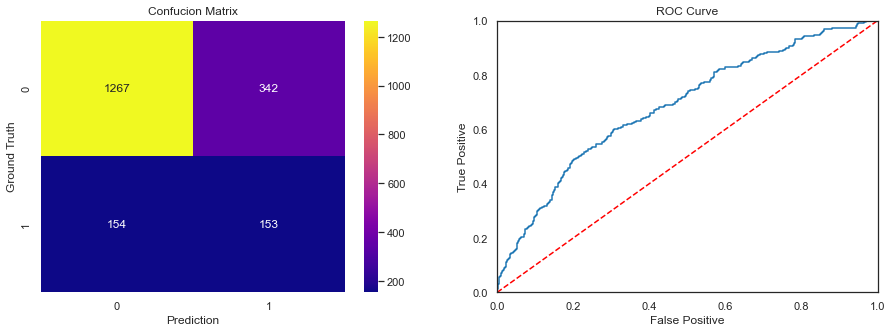

In [70]:
print('Best F1 score is obtained by: {}'.format(svm_smt_res.columns[svm_smt_res.loc['F1 Score'].argmax()]))

y_pred, y_proba, res = logistic_reg(X_tra_re, y_tra_re, X_tes, y_tes,
                                      C_range=np.geomspace(0.1,10,10), class_weight=None)
result_rep(y_tes, y_pred, y_proba)

### Borderline SMOTE <a class="anchor" id="56"></a>

This algorithm is a variant of the original SMOTE algorithm in which Borderline samples will be detected and used to generate new synthetic samples.

In [71]:
bsmt = BorderlineSMOTE(random_state=1979, n_jobs=-1)
X_tra_re, y_tra_re = bsmt.fit_resample(X_tra, y_tra)

bsmt_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df8 = satck_res(bsmt_res, 'BorderlineSMOTE')
bsmt_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.574107,0.574999,0.559133,0.518130,0.547544,0.546390,0.558197,0.537187
Recall,0.628461,0.629704,0.601010,0.526993,0.546027,0.561475,0.557427,0.544975
F1 Score,0.560295,0.561869,0.545319,0.511258,0.546733,0.548332,0.557803,0.538928
Accuracy,0.657098,0.659186,0.650835,0.665971,0.759916,0.715031,0.763570,0.724948
ROC_AUC,0.628461,0.629704,0.601010,0.526993,0.546027,0.561475,0.557427,0.544975


Best F1 score is obtained by: Linear SVC


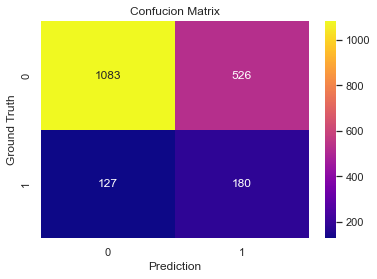

In [72]:
print('Best F1 score is obtained by: {}'.format(bsmt_res.columns[bsmt_res.loc['F1 Score'].argmax()]))

y_pred, res = linear_svc(X_tra_re, y_tra_re, X_tes, y_tes, 
                                   C_range=np.geomspace(0.1,10,10), class_weight=None)
confusion_rep(y_tes, y_pred)

## Under Sampling <a class="anchor" id="sixth-bullet"></a>

In this section, we use another approach to tackle the imbalance of the dataset. Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. 

### RandomUnderSampler <a class="anchor" id="61"></a>

Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset. In this section, we use this method to resample the tarining set. 

In [73]:
rus = RandomUnderSampler(random_state=1979)
X_tra_re, y_tra_re = rus.fit_resample(X_tra, y_tra)

rus_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df9 = satck_res(rus_res, 'RandomUnderSampler')
rus_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.564086,0.564282,0.572704,0.554488,0.566353,0.544797,0.419885,0.557837
Recall,0.615623,0.615934,0.628214,0.599700,0.622565,0.581859,0.500000,0.605293
F1 Score,0.536358,0.536744,0.554368,0.517842,0.523874,0.507275,0.456454,0.524718
Accuracy,0.620042,0.620564,0.645616,0.595511,0.591858,0.587683,0.839770,0.604906
ROC_AUC,0.615623,0.615934,0.628214,0.599700,0.622565,0.581859,0.500000,0.605293


Best F1 score is obtained by: SVC with Kernel


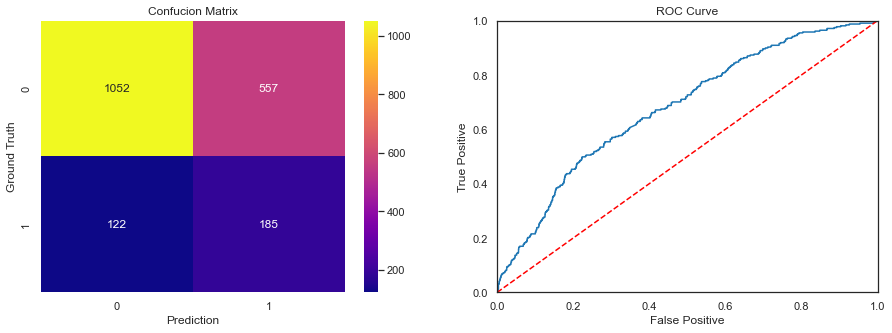

In [74]:
print('Best F1 score is obtained by: {}'.format(rus_res.columns[rus_res.loc['F1 Score'].argmax()]))

y_pred, y_proba, res = kernel_svc(X_tra_re, y_tra_re, X_tes, y_tes, 
                         C_range=np.geomspace(0.1,10,10), class_weight=None)

result_rep(y_tes, y_pred, y_proba)

### ClusterCentroids <a class="anchor" id="62"></a>

This is another method for undersampling. This method under samples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm. 

In [75]:
cc = ClusterCentroids(random_state=1979)
X_tra_re, y_tra_re = cc.fit_resample(X_tra, y_tra)

cc_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df10 = satck_res(cc_res, 'ClusterCentroid')
cc_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.525462,0.525631,0.533123,0.507205,0.520589,0.529582,0.525210,0.521062
Recall,0.547291,0.547602,0.561380,0.512914,0.537527,0.554963,0.543997,0.536228
F1 Score,0.466836,0.467209,0.462607,0.407294,0.431682,0.468000,0.412413,0.402161
Accuracy,0.531837,0.532359,0.515658,0.443111,0.473382,0.529228,0.439979,0.426931
ROC_AUC,0.547291,0.547602,0.561380,0.512914,0.537527,0.554963,0.543997,0.536228


Best F1 score is obtained by: K Nearset Neighbors


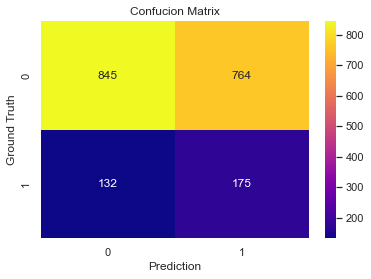

In [76]:
print('Best F1 score is obtained by: {}'.format(cc_res.columns[cc_res.loc['F1 Score'].argmax()]))

y_pred, res = linear_svc(X_tra_re, y_tra_re, X_tes, y_tes, 
                                   C_range=np.geomspace(0.1,10,10), class_weight=None)

confusion_rep(y_tes, y_pred)

### NearMiss <a class="anchor" id="63"></a>

NearMiss is another under-sampling technique in which the class distribution is balanced by randomly eliminating majority class samples.

In [77]:
nm = NearMiss(n_jobs=-1, n_neighbors=10)
X_tra_re, y_tra_re = nm.fit_resample(X_tra, y_tra)

nm_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df11 = satck_res(nm_res, 'NearMiss')
nm_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.532431,0.532596,0.533319,0.533319,0.531933,0.532214,0.531956,0.531161
Recall,0.551699,0.552010,0.553017,0.553017,0.543103,0.556491,0.543650,0.545065
F1 Score,0.385719,0.386153,0.385917,0.385917,0.341475,0.421569,0.344183,0.357298
Accuracy,0.399791,0.400313,0.399791,0.399791,0.345511,0.449896,0.348643,0.364301
ROC_AUC,0.551699,0.552010,0.553017,0.553017,0.543103,0.556491,0.543650,0.545065


Best F1 score is obtained by: K Nearset Neighbors


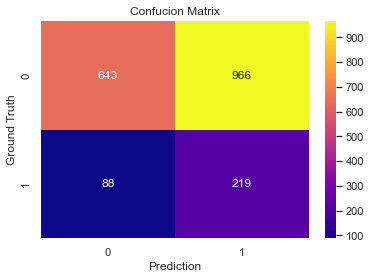

In [78]:
print('Best F1 score is obtained by: {}'.format(nm_res.columns[nm_res.loc['F1 Score'].argmax()]))

y_pred, res = k_neighbors(X_tra_re, y_tra_re, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
confusion_rep(y_tes, y_pred)

### TomekLinks <a class="anchor" id="64"></a>

TomekLinks is another technique for undersampling in which under-sampling is carried out by removing Tomek's links (pairs of instances of opposite classes who are their own nearest neighbors). 

In [79]:
tl = TomekLinks(n_jobs=-1)
X_tra_re, y_tra_re = tl.fit_resample(X_tra, y_tra)

tl_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df12 = satck_res(tl_res, 'TomekLinks')
tl_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.754814,0.670063,0.702829,0.512190,0.569006,0.537878,0.545168,0.583543
Recall,0.511786,0.501318,0.512483,0.513345,0.507125,0.542586,0.502089,0.524247
F1 Score,0.481953,0.459665,0.484404,0.512403,0.478498,0.539477,0.464856,0.516342
Accuracy,0.841858,0.839770,0.840814,0.724948,0.834029,0.736430,0.836639,0.825157
ROC_AUC,0.511786,0.501318,0.512483,0.513345,0.507125,0.542586,0.502089,0.524247


Best F1 score is obtained by: K Nearset Neighbors


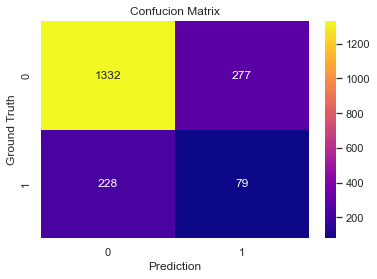

In [80]:
print('Best F1 score is obtained by: {}'.format(tl_res.columns[tl_res.loc['F1 Score'].argmax()]))

y_pred, res = k_neighbors(X_tra_re, y_tra_re, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
confusion_rep(y_tes, y_pred)

### EditedNearestNeighbours <a class="anchor" id="65"></a>

This is another technique for undersampling where the dataset is cleaned by removing samples close to the decision boundary. 

In [81]:
enn = EditedNearestNeighbours(n_jobs=-1)
X_tra_re, y_tra_re = enn.fit_resample(X_tra, y_tra)

enn_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df13 = satck_res(enn_res, 'EditedNearestNeighbours')
enn_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.612339,0.610662,0.635955,0.537411,0.604348,0.550298,0.612781,0.587263
Recall,0.582834,0.574155,0.593624,0.557391,0.583755,0.580181,0.572763,0.592015
F1 Score,0.592371,0.584121,0.606567,0.531910,0.591251,0.543967,0.583029,0.589448
Accuracy,0.808455,0.811587,0.819937,0.672756,0.801148,0.671190,0.813674,0.772965
ROC_AUC,0.582834,0.574155,0.593624,0.557391,0.583755,0.580181,0.572763,0.592015


Best F1 score is obtained by: SVC with Kernel


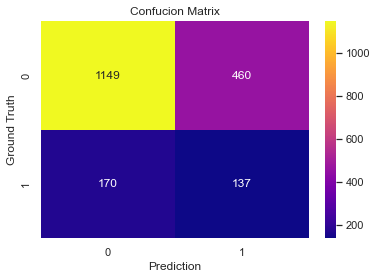

In [82]:
print('Best F1 score is obtained by: {}'.format(enn_res.columns[enn_res.loc['F1 Score'].argmax()]))

y_pred, res = k_neighbors(X_tra_re, y_tra_re, X_tes, y_tes, n_neighbors=[1, 3, 5,7, 10, 15, 20, 50])
confusion_rep(y_tes, y_pred)

## Combination of Over- and Under-Sampling Methods <a class="anchor" id="seventh-bullet"></a>

### SMOTETomek <a class="anchor" id="71"></a>

This is a technique that combines both undersampling (using Tomek's Links) and oversampling (using SMOTE) to address the issue of the imbalance of the dataset. 

In [83]:
smt_tom = SMOTETomek(random_state=1979, n_jobs=-1)
X_tra_re, y_tra_re = smt_tom.fit_resample(X_tra, y_tra)

smt_tom_res = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df14 = satck_res(smt_tom_res, 'SMOTETomek')
smt_tom_res

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.568739,0.568941,0.547212,0.524684,0.567097,0.542102,0.555767,0.539951
Recall,0.623156,0.623467,0.582836,0.538532,0.564414,0.558667,0.555177,0.549314
F1 Score,0.544611,0.545000,0.525280,0.515459,0.565662,0.542239,0.555466,0.541879
Accuracy,0.630480,0.631002,0.624739,0.656576,0.770877,0.701461,0.762004,0.723382
ROC_AUC,0.623156,0.623467,0.582836,0.538532,0.564414,0.558667,0.555177,0.549314


Best F1 score is obtained by: Random Forest


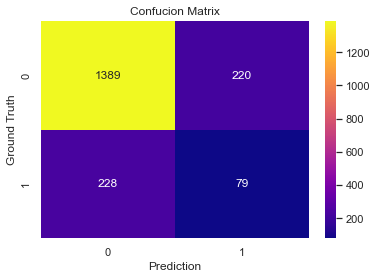

In [84]:
print('Best F1 score is obtained by: {}'.format(smt_tom_res.columns[smt_tom_res.loc['F1 Score'].argmax()]))

y_pred, res = random_forest(X_tra_re, y_tra_re, X_tes, y_tes, max_depth=np.linspace(3,1000,10, dtype=int),
                                n_estimators=[100, 300, 500, 1000], class_weight=None)
confusion_rep(y_tes, y_pred)

### SMOTEENN <a class="anchor" id="72"></a>

This is a method that combines over- and under-sampling techniques using SMOTE and Edited Nearest Neighbours.

In [85]:
smt_enn = SMOTEENN(random_state=1979, n_jobs=-1)
X_tra_re, y_tra_re = smt_enn.fit_resample(X_tra, y_tra)

smt_enn = classification_different_models(X_tra_re, y_tra_re, X_tes, y_tes, class_weight=None)
df15 = satck_res(smt_enn, 'SMOTEENN')
smt_enn

,Logistic Regression,Linear SVC,SVC with Kernel,Decision Tree,Random Forest,K Nearset Neighbors,Bagging Classifier,Gradient Boosting
Precision,0.562818,0.561673,0.558397,0.535658,0.560370,0.543152,0.553047,0.549686
Recall,0.609080,0.606594,0.603434,0.563506,0.608798,0.577767,0.598049,0.590399
F1 Score,0.446985,0.443634,0.452874,0.507278,0.532413,0.512000,0.507729,0.515428
Accuracy,0.471816,0.467641,0.482255,0.603340,0.617432,0.600731,0.577244,0.597599
ROC_AUC,0.609080,0.606594,0.603434,0.563506,0.608798,0.577767,0.598049,0.590399


Best F1 score is obtained by: Random Forest


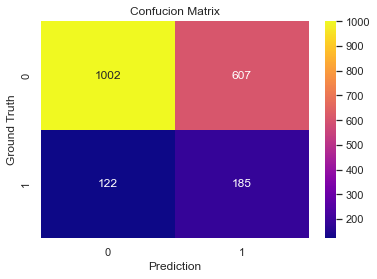

In [86]:
print('Best F1 score is obtained by: {}'.format(smt_enn.columns[smt_enn.loc['F1 Score'].argmax()]))

y_pred, res = random_forest(X_tra_re, y_tra_re, X_tes, y_tes, max_depth=np.linspace(3,1000,10, dtype=int),
                                n_estimators=[100, 300, 500, 1000], class_weight=None)
confusion_rep(y_tes, y_pred)

## Final Results <a class="anchor" id="eighth-bullet"></a>

Now, it is time to review and compare the obtained results by different samplers. In what follows, we will compare the samplers to see which one results in the best F1 score and accuracy. Furthermore, we will compare the different classification methods to see which one provides better results when an appropriate sampler is chosen. 

Let first merge the obtained results by different samplers into 'final_res' dataframe:

In [88]:
final_res = pd.concat([df1, df2, df3, df4, df5, 
                       df6, df7, df8, df9, df10,
                       df11, df12, df13, df14, df15])

As one can see below, the best F1 score (F1 score:0.608925) is obtained by SVMSMOTE technique. This value is obtained using a logistic regression classifier.

Similarly, the best Accuracy is obtained by using 'class weight' with the logistic regression classifier.

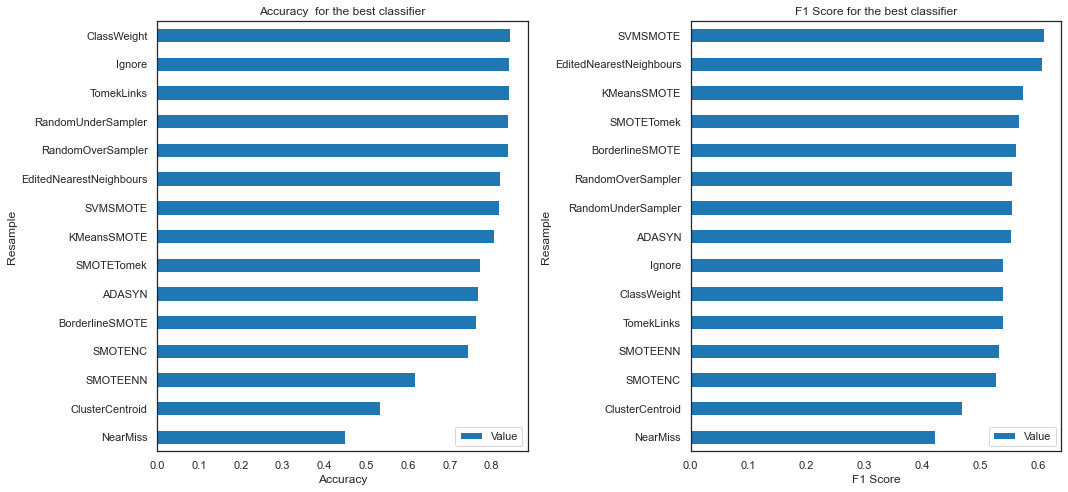

In [89]:
fig , axs = plt.subplots(1,2, figsize=(15,7))

pd.DataFrame(final_res.groupby(['Metric', 'Resample'])['Value'].max()
            ).loc['Accuracy'].sort_values(by='Value').plot.barh(ax=axs[0])
axs[0].set(title='Accuracy  for the best classifier', xlabel='Accuracy')

pd.DataFrame(final_res.groupby(['Metric', 'Resample'])['Value'].max()
            ).loc['F1 Score'].sort_values(by='Value').plot.barh(ax=axs[1])
axs[1].set(title='F1 Score for the best classifier', xlabel='F1 Score')

plt.tight_layout()

In the following, we compare different classifiers. As one can see for our dataset, all the classifiers (unless Decision tree and K Nearest Neighbors) may lead to approximately the same maximum Accuracy and F1 score if a suitable tailored sampler is employed. 

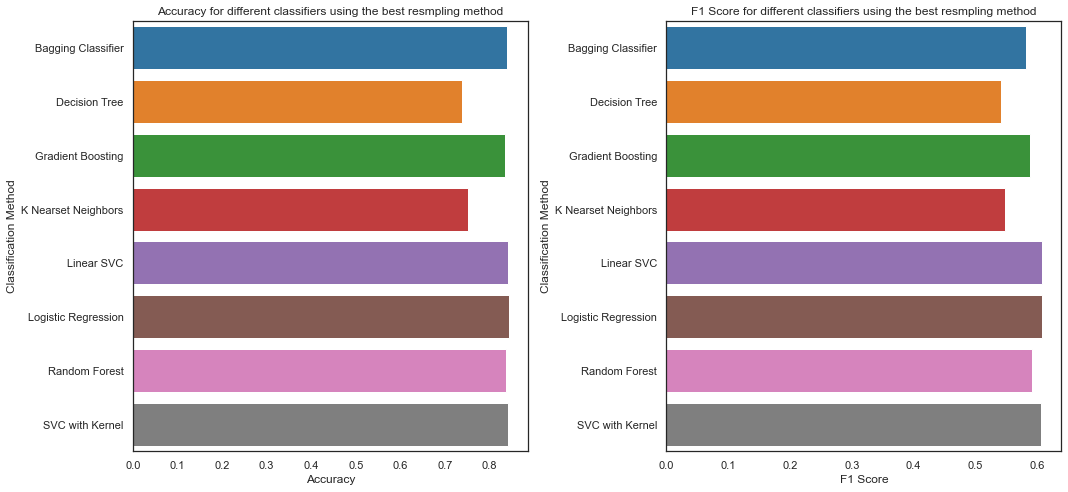

In [90]:
data_rep = final_res.groupby(['Metric','Classification Method'], as_index=False)['Value'].max()

fig , axs = plt.subplots(1,2, figsize=(15,7))

data_rep_acc = data_rep[data_rep['Metric']=='Accuracy']
sns.barplot(x='Value', y='Classification Method', data=data_rep_acc, ax=axs[0])
axs[0].set(title='Accuracy for different classifiers using the best resmpling method', xlabel='Accuracy')

data_rep_acc = data_rep[data_rep['Metric']=='F1 Score']
sns.barplot(x='Value', y='Classification Method', data=data_rep_acc, ax=axs[1])
axs[1].set(title='F1 Score for different classifiers using the best resmpling method', xlabel='F1 Score')

plt.tight_layout()


To recap, the above results emphasize that for our dataset choosing an appropriate sampler is much more important than choosing the classifier. If an appropriate sampler is chosen  then almost all the classifiers  (unless Decision tree and K Nearset Neighbors) may lead to similar F1 and Accuracy scores. However, note that the optimal sampler may vary for different classifiers. As it becomes clear in the following:

In [125]:
idx = (final_res.groupby(['Classification Method', 'Metric'])['Value'].transform(max)== final_res['Value'])
final_res[idx & (final_res['Metric']=='F1 Score')]

,Metric,Classification Method,Value,Resample
19,F1 Score,Decision Tree,0.541995,KMeansSMOTE
16,F1 Score,Logistic Regression,0.608925,SVMSMOTE
17,F1 Score,Linear SVC,0.607980,SVMSMOTE
21,F1 Score,K Nearset Neighbors,0.548332,BorderlineSMOTE
18,F1 Score,SVC with Kernel,0.606567,EditedNearestNeighbours
20,F1 Score,Random Forest,0.591251,EditedNearestNeighbours
22,F1 Score,Bagging Classifier,0.583029,EditedNearestNeighbours
23,F1 Score,Gradient Boosting,0.589448,EditedNearestNeighbours


As one can see, Logistic Regression and LinearSVC using SVMSMOTE result in approximately the same maximum values for F1 score.

On the other hand, SVC with Kernel, Random Forest, Bagging Classifier, Gradient Boosting result in approximately the same maximum values for F1 score.

In [126]:
idx = (final_res.groupby(['Classification Method', 'Metric'])['Value'].transform(max)== final_res['Value'])
final_res[idx & (final_res['Metric']=='Accuracy')]

,Metric,Classification Method,Value,Resample
27,Accuracy,Decision Tree,0.737474,Ignore
28,Accuracy,Random Forest,0.837683,Ignore
29,Accuracy,K Nearset Neighbors,0.751566,Ignore
24,Accuracy,Logistic Regression,0.843946,ClassWeight
25,Accuracy,Linear SVC,0.842902,ClassWeight
26,Accuracy,SVC with Kernel,0.842380,ClassWeight
29,Accuracy,K Nearset Neighbors,0.751566,ClassWeight
31,Accuracy,Gradient Boosting,0.834029,ClassWeight
27,Accuracy,Decision Tree,0.737474,RandomOverSampler
29,Accuracy,K Nearset Neighbors,0.751566,RandomOverSampler


As one can see,  Logistic Regression, Linear SVC, SVC with Kernel, and Gradient Boostiung using the Class-weight capability result in the approximately the same maximum values for the Accuracy, where Bagging Classifier using RandomUnderSampler and Random Forest by ignoring the imbalance of the dataset result in approxiamtely the same maximum values for the Accuracy. 